<a href="https://colab.research.google.com/github/wakamezake/Notebooks/blob/master/Using_Albumentations_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References
- https://albumentations.ai/docs/examples/tensorflow-example/

# Library

In [1]:
!pip install -q -U albumentations

     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 36.7MB 86kB/s 
     |████████████████████████████████| 952kB 45.3MB/s 


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Datasets
- https://www.tensorflow.org/datasets/catalog/tf_flowers

In [3]:
data, info= tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
NUM_CLASSES = info.features['label'].num_classes

In [5]:
WIDTH, HEIGHT = 224, 224
IMAGE_SIZE = WIDTH, HEIGHT

# Settings

In [6]:
EPOCHS = 3

# Augmentations

In [7]:
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

In [8]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(WIDTH, HEIGHT, 3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

In [9]:
ds_alb = data.map(partial(process_data, img_size=WIDTH),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset shapes: (<unknown>, ()), types: (tf.float32, tf.int64)>

In [10]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

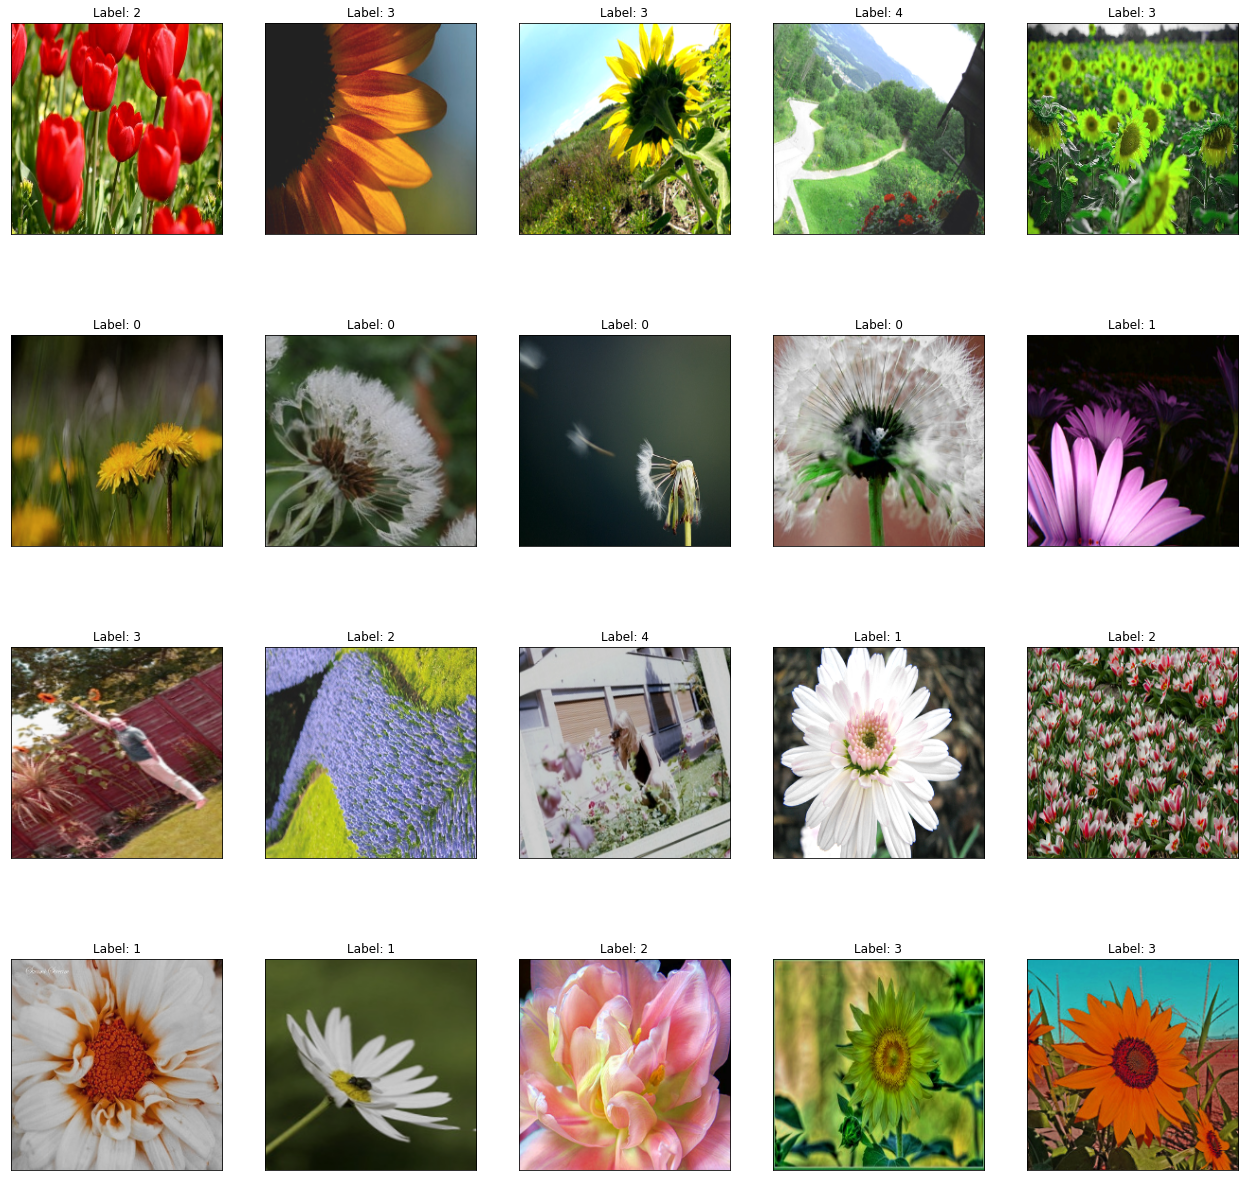

In [11]:
view_image(ds_alb)

# Setup Model

In [12]:
feature_extractor_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(WIDTH, HEIGHT, 3))

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(NUM_CLASSES, activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [17]:
model.fit(ds_alb, epochs=EPOCHS)

Epoch 1/3
115/115 [==============================] - 23s 202ms/step - loss: 0.6911 - accuracy: 0.7624
Epoch 2/3
115/115 [==============================] - 20s 174ms/step - loss: 0.3507 - accuracy: 0.8894
Epoch 3/3
115/115 [==============================] - 20s 177ms/step - loss: 0.2797 - accuracy: 0.9136
